MSE Simulated Annealing: 101.07619555929783
MSE SGD: 100.96689190852736


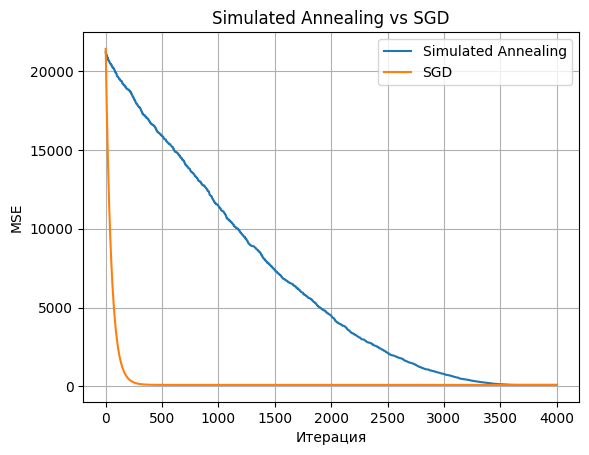

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_regression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

X, y = make_regression(n_samples=500, n_features=10, noise=10.0, random_state=42)
X = StandardScaler().fit_transform(X)
y = y.astype(np.float32)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

class SimulatedAnnealingRegressor:
    def __init__(self, max_iter=4000, initial_temp=1.0, cooling_rate=0.99):
        self.max_iter = max_iter
        self.initial_temp = initial_temp
        self.cooling_rate = cooling_rate

    def _loss(self, X, y, w):
        return np.mean((X @ w - y) ** 2)

    def _perturb(self, w):
        return w + np.random.normal(scale=0.1, size=w.shape)

    def fit(self, X, y):
        n_features = X.shape[1]
        current_w = np.random.randn(n_features)
        best_w = current_w.copy()
        current_loss = self._loss(X, y, current_w)
        best_loss = current_loss
        T = self.initial_temp

        self.losses = [current_loss]

        for _ in range(self.max_iter):
            new_w = self._perturb(current_w)
            new_loss = self._loss(X, y, new_w)

            if new_loss < current_loss or np.random.rand() < np.exp(-(new_loss - current_loss) / T):
                current_w = new_w
                current_loss = new_loss
                if new_loss < best_loss:
                    best_w = new_w
                    best_loss = new_loss

            self.losses.append(current_loss)
            T *= self.cooling_rate

        self.w = best_w

    def predict(self, X):
        return X @ self.w

class SimpleSGD:
    def __init__(self, lr=0.01, epochs=4000):
        self.lr = lr
        self.epochs = epochs

    def fit(self, X, y):
        self.w = np.zeros(X.shape[1])
        self.losses = []

        for _ in range(self.epochs):
            error = X @ self.w - y
            grad = X.T @ error / len(X)
            self.w -= self.lr * grad
            loss = np.mean(error**2)
            self.losses.append(loss)

    def predict(self, X):
        return X @ self.w

annealing = SimulatedAnnealingRegressor()
annealing.fit(X_train, y_train)
pred_sa = annealing.predict(X_val)

sgd = SimpleSGD()
sgd.fit(X_train, y_train)
pred_sgd = sgd.predict(X_val)

print("MSE Simulated Annealing:", mean_squared_error(y_val, pred_sa))
print("MSE SGD:", mean_squared_error(y_val, pred_sgd))

plt.plot(annealing.losses, label='Simulated Annealing')
plt.plot(sgd.losses, label='SGD')
plt.xlabel("Epoch")
plt.ylabel("MSE")
plt.title("Simulated Annealing vs SGD")
plt.legend()
plt.grid(True)
plt.show()


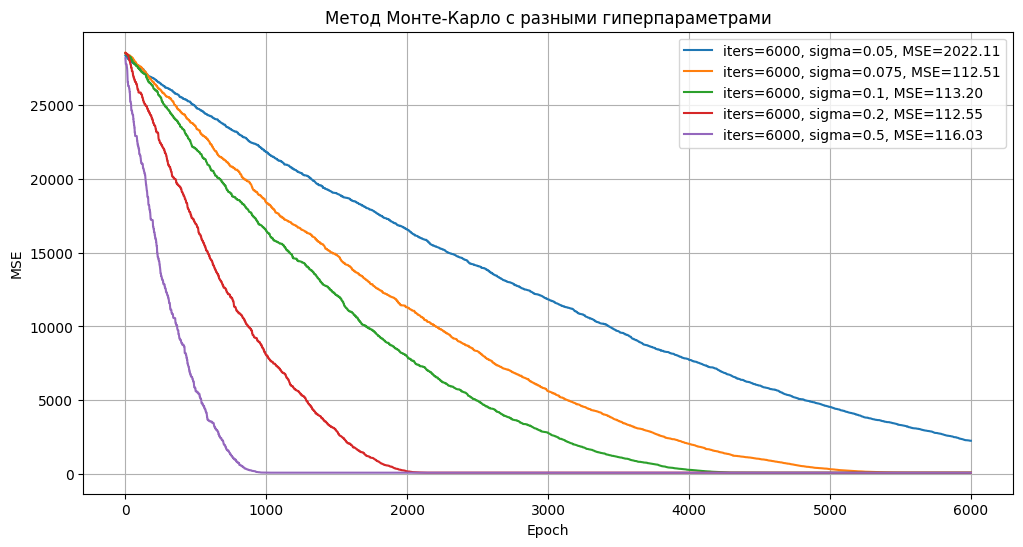

In [17]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_regression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

X, y = make_regression(n_samples=1000, n_features=15, noise=10.0, random_state=42)
X = StandardScaler().fit_transform(X)
y = y.astype(np.float32)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

class MonteCarloRegressor:
    def __init__(self, iters=1000, sigma=0.1, init_scale=1.0):
        self.iters = iters
        self.sigma = sigma
        self.init_scale = init_scale

    def _loss(self, X, y, w):
        return np.mean((X @ w - y) ** 2)

    def fit(self, X, y):
        n_features = X.shape[1]
        self.w = np.random.randn(n_features) * self.init_scale
        best_loss = self._loss(X, y, self.w)
        self.losses = [best_loss]

        for _ in range(self.iters):
            w_new = self.w + np.random.normal(0, self.sigma, size=self.w.shape)
            loss = self._loss(X, y, w_new)

            if loss < best_loss:
                self.w = w_new
                best_loss = loss

            self.losses.append(best_loss)

    def predict(self, X):
        return X @ self.w

configs = [
    {"iters": 6000, "sigma": 0.05},
    {"iters": 6000, "sigma": 0.075},
    {"iters": 6000, "sigma": 0.1},
    {"iters": 6000, "sigma": 0.2},
    {"iters": 6000, "sigma": 0.5},
]

plt.figure(figsize=(12, 6))
for config in configs:
    model = MonteCarloRegressor(iters=config["iters"], sigma=config["sigma"])
    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)
    mse = mean_squared_error(y_val, y_pred)
    label = f"iters={config['iters']}, sigma={config['sigma']}, MSE={mse:.2f}"
    plt.plot(model.losses, label=label)

plt.xlabel("Epoch")
plt.ylabel("MSE")
plt.title("Метод Монте-Карло с разными гиперпараметрами")
plt.legend()
plt.grid(True)
plt.show()


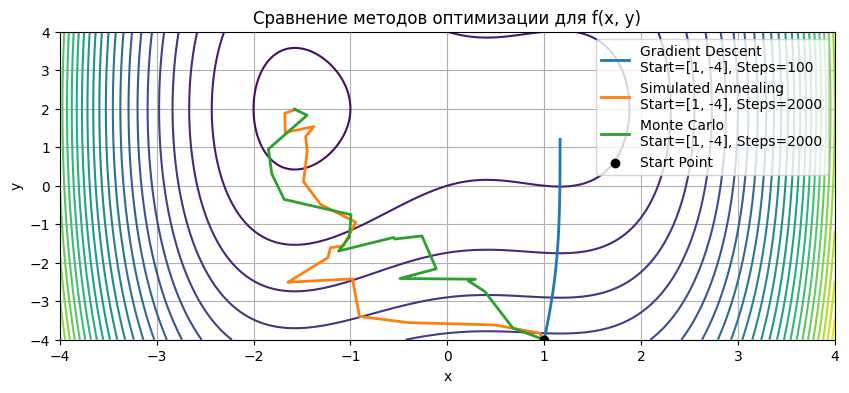

In [24]:
import numpy as np
import matplotlib.pyplot as plt

def f(x, y):
    return x**4 - 4*x**2 + y**2 + 3*x - 4*y

def grad_f(x, y):
    df_dx = 4*x**3 - 8*x + 3
    df_dy = 2*y - 4
    return np.array([df_dx, df_dy])

def gradient_descent(start, lr=0.01, epochs=100):
    path = [start]
    x = np.array(start, dtype=np.float32)
    for _ in range(epochs):
        grad = grad_f(x[0], x[1])
        x -= lr * grad
        path.append(x.copy())
    return np.array(path)

def simulated_annealing(start, iters=2000, initial_temp=1.0, cooling_rate=0.9):
    x = np.array(start, dtype=np.float32)
    best = x.copy()
    best_val = f(x[0], x[1])
    T = initial_temp
    path = [x.copy()]
    for _ in range(iters):
        new_x = x + np.random.normal(scale=0.5, size=2)
        new_val = f(new_x[0], new_x[1])
        if new_val < best_val or np.random.rand() < np.exp(-(new_val - best_val) / T):
            x = new_x
            if new_val < best_val:
                best = new_x
                best_val = new_val
        T *= cooling_rate
        path.append(x.copy())
    return np.array(path)

def monte_carlo(start, iters=2000, sigma=0.5):
    x = np.array(start, dtype=np.float32)
    best = x.copy()
    best_val = f(x[0], x[1])
    path = [x.copy()]
    for _ in range(iters):
        candidate = best + np.random.normal(scale=sigma, size=2)
        val = f(candidate[0], candidate[1])
        if val < best_val:
            best = candidate
            best_val = val
        path.append(best.copy())
    return np.array(path)

start_point = [1, -4]

gd_path = gradient_descent(start_point, lr=0.01, epochs=100)
sa_path = simulated_annealing(start_point, iters=2000)
mc_path = monte_carlo(start_point, iters=2000)

plt.figure(figsize=(10, 4))

x_vals = np.linspace(-4, 4, 400)
y_vals = np.linspace(-4, 4, 400)
X, Y = np.meshgrid(x_vals, y_vals)
Z = f(X, Y)
plt.contour(X, Y, Z, levels=25, cmap='viridis')

plt.plot(gd_path[:, 0], gd_path[:, 1], label=f'Gradient Descent\nStart={start_point}, Steps=100', lw=2)
plt.plot(sa_path[:, 0], sa_path[:, 1], label=f'Simulated Annealing\nStart={start_point}, Steps=2000', lw=2)
plt.plot(mc_path[:, 0], mc_path[:, 1], label=f'Monte Carlo\nStart={start_point}, Steps=2000', lw=2)

plt.scatter(*start_point, color='black', label='Start Point', zorder=5)

plt.title('Сравнение методов оптимизации для f(x, y)')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.grid(True)
plt.show()
